In [1]:
import pandas as pd
import numpy as np
from scipy import optimize
import sys
sys.path.append('../../')
from PortfolioAnalysis import Backtest
from PortfolioAnalysis import Model

In [2]:
def inv(df):
    return pd.DataFrame(np.linalg.pinv(df.values), df.columns, df.index)

In [37]:
class BL:
    '''
    Black-Litterman is used to get the final combination weight
    Input:
    
    
    
    '''
    def __init__(self, df_date, df_history, df_fr, market_view, sub_view):
        self.df_date = df_date
        self.df_history = df_history
        self.df_fr = df_fr

        # market_view为风险评价模型观点矩阵
        # sub_view为宏观数据算出的主观观点矩阵
        self.market_view = market_view
        self.sub_view = sub_view
        
        # 权重
        ay_weight = self.market_view.iloc[[0]]
        
        # 期望收益率平均值
        df_r = np.log(df_history/df_history.shift(1))
        market_r = (self.market_view*np.array(df_r)).dropna()
        E_r = market_r.sum().sum()
        
        # 收益率标准差
        market_sigma = np.std(market_r.sum(axis=1))
        
        # 无风险利率平均值
        mean_fr = df_fr.mean()
        
        # 风险厌恶系数
        Lambda = ((E_r-mean_fr)/(market_sigma))[0]
        self.Lambda = Lambda
        
        # 资产收益率协方差矩阵(n*n)
        market_cov = df_r.corr() 
        
        # 先验收益率（n*1） = Lambda*协方差矩阵（n*n）*权重（n*1）
        Sigma = Lambda * np.dot(market_cov , ay_weight.T)
        self.Sigma = Sigma
        
        # 观点收益Q
        sub_view = self.sub_view
        Q = sub_view[sub_view.columns[len(sub_view.columns)-1]] .sum()
        
        # 观点信心水平LC默认为80%
        LC = 0.8
        
        # CF
        P = (self.sub_view.sum(axis=0))[:-1]
        P = pd.DataFrame(P).T
        CF = np.dot(np.dot(P,market_cov),P.T)[0]
        
        # 观点误差矩阵
        Omega = pd.DataFrame([CF/LC])
        
        # 投资者信心程度，默认为1
        tao = 1
        self.tao = tao
        
        # 后验收益率 E(R)
        E_R = np.dot(inv(inv(tao*market_cov)+np.dot(np.dot(P.T,inv(Omega)),P)),\
                         (np.dot(inv(tao*market_cov),self.Sigma)+(np.dot(np.dot(P.T,inv(Omega)),Q))))
        self.E_R = E_R
        
        # 新收益率协方差矩阵
        new_cov = inv(inv(tao*market_cov)+np.dot(np.dot(P.T,inv(Omega)),P))
       
        # 新的权重
        weight_new = inv(Lambda*new_cov).dot(E_R).T
        for i in range(62):
            weight_new = weight_new.append(weight_new.iloc[0]) 
        weight_new.index = self.df_date
        self.weight_new = weight_new
        
    
    def print_E_R(self):
        return self.E_R
    
    def print_weight(self):
        return self.weight_new
        

In [83]:
market_view = pd.read_csv("../Risk_Parity_Model/view.csv",index_col = 0)
sub_view = pd.read_csv("../Subjective_View_Setting/Subjective_View.csv",index_col = 0)
df_history = pd.read_csv("../../Data/Data_Outsample.csv",index_col = 0)[:-28]
df_history_all = pd.read_csv("../../Data/Data_All.csv",index_col = 0)
df_date = market_view.index
df_fr = pd.DataFrame(np.repeat(0,1134))

In [84]:
view_new = pd.DataFrame(columns = df_history.columns)
start = 0
while(True):
    print("start = %d"%start)
    if(start+63>len(df_date)):
        break
    bl = BL(df_date[start:start+63], df_history[start:start+63], df_fr[start:start+63],\
            market_view[start:start+63], sub_view[start:start+63])
    view_new = pd.concat([view_new,bl.print_weight()])
    start = start + 63
    

start = 0
start = 63
start = 126
start = 189
start = 252
start = 315
start = 378
start = 441
start = 504
start = 567
start = 630
start = 693
start = 756
start = 819
start = 882
start = 945
start = 1008
start = 1071
start = 1134


In [85]:
view_new

,上证指数,沪深300,能源指数,工业指数,医疗保健指数,公用事业指数,中债-信用债总财富(总值)指数,中债-企业债总财富(总值)指数,中债-国开行债券总财富(总值)指数,南华农产品指数,黄金指数,日常消费指数,材料指数,电信服务指数,恒生综指
2016-03-29,0.008124,0.007894,0.008760,0.006748,0.008260,0.006261,0.287433,0.289289,0.288357,0.040869,0.006287,0.007818,0.007137,0.007688,0.015085
2016-03-30,0.008124,0.007894,0.008760,0.006748,0.008260,0.006261,0.287433,0.289289,0.288357,0.040869,0.006287,0.007818,0.007137,0.007688,0.015085
2016-03-31,0.008124,0.007894,0.008760,0.006748,0.008260,0.006261,0.287433,0.289289,0.288357,0.040869,0.006287,0.007818,0.007137,0.007688,0.015085
2016-04-01,0.008124,0.007894,0.008760,0.006748,0.008260,0.006261,0.287433,0.289289,0.288357,0.040869,0.006287,0.007818,0.007137,0.007688,0.015085
2016-04-05,0.008124,0.007894,0.008760,0.006748,0.008260,0.006261,0.287433,0.289289,0.288357,0.040869,0.006287,0.007818,0.007137,0.007688,0.015085
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-17,0.011058,0.005186,0.007333,0.005749,0.009781,0.006732,0.291869,0.293639,0.287418,0.045128,0.005275,0.005746,0.005838,0.005752,0.013656
2020-11-18,0.011058,0.005186,0.007333,0.005749,0.009781,0.006732,0.291869,0.293639,0.287418,0.045128,0.005275,0.005746,0.005838,0.005752,0.013656
2020-11-19,0.011058,0.005186,0.007333,0.005749,0.009781,0.006732,0.291869,0.293639,0.287418,0.045128,0.005275,0.005746,0.005838,0.005752,0.013656
2020-11-20,0.011058,0.005186,0.007333,0.005749,0.009781,0.006732,0.291869,0.293639,0.287418,0.045128,0.005275,0.005746,0.005838,0.005752,0.013656


In [86]:
df_date

Index(['2016-03-29', '2016-03-30', '2016-03-31', '2016-04-01', '2016-04-05',
       '2016-04-06', '2016-04-07', '2016-04-08', '2016-04-11', '2016-04-12',
       ...
       '2020-11-10', '2020-11-11', '2020-11-12', '2020-11-13', '2020-11-16',
       '2020-11-17', '2020-11-18', '2020-11-19', '2020-11-20', '2020-11-23'],
      dtype='object', name='时间', length=1134)

In [87]:
df_fr

,0
0,0
1,0
2,0
3,0
4,0
...,...
1129,0
1130,0
1131,0
1132,0


In [88]:
BT = Backtest.Backtest(df_date, df_history_all[252*3:252*3+63*18], view_new, df_fr, 'D')
BT.get_info()

,Sharpe,Annualized Return,Annualized Volatility,Maximum Drawdown
Value,0.079477,0.054022,0.679717,0.059789


In [89]:
df_bm = pd.DataFrame(np.repeat(np.array([[1/15,]*15]),63*18,axis=0))

In [90]:
BTM = Backtest.Backtest(df_date, df_history_all[252*3:252*3+63*18], df_bm, df_fr, 'D')
BTM.get_info()

,Sharpe,Annualized Return,Annualized Volatility,Maximum Drawdown
Value,0.025518,0.087254,3.419271,0.774552


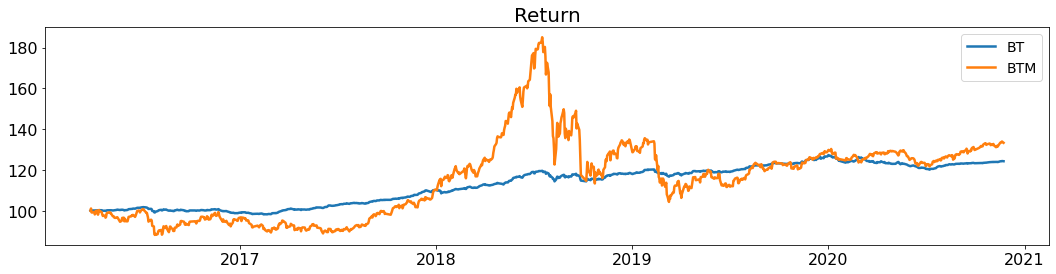

In [91]:
Backtest.Plot2(df_date,BT.df_asset,BTM.df_asset,"Return","BT","BTM")